In [1]:
from fetch import loaNFTfiHistory
import warnings
warnings.filterwarnings('ignore')

loan_info = loaNFTfiHistory()

In [2]:
loan_info

,borrower,lender,nftCollateralContract,nftCollateralId,loanDuration,loanStartTime,loanPrincipalAmount,maximumRepaymentAmount,apr,loanERC20Denomination,loanLiquidated,LTV,FP
0,0xf2b10b41961f6bc3801e7946dabe5572158a78a5,0x762494a4d00d28d8a95f0935b0934fd9bcd69528,0x364c828ee171616a39897688a831c2499ad972ec,4950,30.0,2022-04-06,0.500000,0.534932,85.0,wETH,True,NaN,NaN
1,0xd90022c09c5c44d9c98b0035fd391643be1cec49,0x0aff497bd016000185b1c8302fa98a88ff4a4178,0x75e95ba5997eb235f40ecf8347cdb11f18ff640b,6530,30.0,2022-04-06,2.000000,2.095342,58.0,wETH,True,NaN,NaN
2,0x3203e254149d9ce8bc370647ea5077efa17a4195,0x0aff497bd016000185b1c8302fa98a88ff4a4178,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,586,14.0,2022-04-07,65.000000,66.371233,55.0,wETH,True,0.733441,88.623293
3,0x9cfaa61d21437a731ac905edeb3674de1e77c8ad,0x2c35b3d207f745ad5b17d88328286c49a0ce4d4f,0x059edd72cd353df5106d2b9cc5ab83a52287ac3a,2472,90.0,2022-04-07,6.000000,6.739726,50.0,wETH,True,0.857143,7.000000
4,0x7a1793c4cfd4780e96d5b70d9ae8bcc01dc832bd,0x24e471b7b5f9b6a3ff73cb52be3fffb7592e4ebf,0xeaa4c58427c184413b04db47889b28b5c98ebb7b,331,30.0,2022-04-07,6.500000,6.847260,65.0,wETH,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18865,0x0aff497bd016000185b1c8302fa98a88ff4a4178,0xe0b719276ef8caa36c00ba3ac7b46bdbcb254c45,0xbd3531da5cf5857e7cfaa92426877b022e612cf8,6076,90.0,2022-04-24,1.700000,1.867671,40.0,wETH,False,NaN,NaN
18866,0x0b8b0a626a397af6448d2a400f4798d897582cd9,0x86a58e8926ae80b7e7477474c8d63c19ac925e60,0xccc441ac31f02cd96c153db6fd5fe0a2f4e6a68d,7063,30.0,2022-04-24,2.500000,2.641781,69.0,wETH,False,NaN,NaN
18867,0x208b82b04449cd51803fae4b1561450ba13d9510,0xf6b1690508b970adeba7633c6cbe7bb0b7d64318,0x5cc5b05a8a13e3fbdb0bb9fccd98d38e50f90c38,81550,30.0,2022-04-25,1.091403,1.172137,90.0,wETH,False,NaN,NaN
18868,0x208b82b04449cd51803fae4b1561450ba13d9510,0xf6b1690508b970adeba7633c6cbe7bb0b7d64318,0x5cc5b05a8a13e3fbdb0bb9fccd98d38e50f90c38,81958,30.0,2022-04-25,1.091403,1.173931,92.0,wETH,False,NaN,NaN


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from info import CONTRACT_ADDRESS, FP_QUERY_ID, TRADES_QUERY_ID
from fetch import fetch_table

def computeProfitAfterSale(loan_info: pd.Series, contract_name: str):
    trade_info = fetch_table(TRADES_QUERY_ID[contract_name])
    liquidated_loan_info = loan_info[
        (loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[contract_name]) * loan_info["loanLiquidated"]
    ]
    nft_token_id = trade_info["nft_token_ids_array"].apply(lambda x: x[0] if len(x) else float("nan")).astype(float)
    sold_datetime = trade_info["block_time"].apply(pd.to_datetime).dt.date
    
    profits = []
    for _, liquidated_loan in liquidated_loan_info.iterrows():
        related_trades = trade_info[
            (nft_token_id == liquidated_loan["nftCollateralId"])
            * (sold_datetime > liquidated_loan["loanStartTime"])
        ]

        if len(related_trades) > 0:
            related_trade = related_trades.iloc[0]
            sold_price = related_trade["original_amount"]
            principal_money = liquidated_loan["loanPrincipalAmount"]

            profit = sold_price / principal_money
            profits.append(profit)

    profits = pd.Series(profits)
    print
    print(f"""
        {contract_name} profit after liquidation: 
             #Liquidated {len(liquidated_loan_info)}, 
             #Sold {len(profits)}, 
             Ratio: {len(profits)/float(len(liquidated_loan_info))} 
             Average Profit {profits.mean()*100:2f}%
             Median Profit {profits.median()*100:2f}%"
        """)


# 지표를 뽑자
def print_stat(loan_info):
    # Average APR BAYC
    print(f'# Unique loan: {len(loan_info)}')
    print(f'Loan total amount: {loan_info[loan_info["loanERC20Denomination"]=="wETH"]["maximumRepaymentAmount"].sum()} wETH')
    print(f'Average principal amount: {loan_info["loanPrincipalAmount"].mean()}')
    # print(f'Unique NFT. {len(loan_info["nftCollateralId"].unique())}')
    
    # NFT Holders
    from collections import defaultdict
    counter = defaultdict(set)  
    for holder_account, nft_address in zip(loan_info["borrower"], loan_info["nftCollateralId"]):
        counter[holder_account].add(nft_address)

    counter = {k: len(v) for k, v in counter.items()}
    histogram = list(counter.values())
    print(f'# Unique borrower. {len(loan_info["borrower"].unique())}')
    plt.title(f"Histogram of number of nft that each borrower holds")
    plt.hist(histogram, bins=list(range(30)))
    plt.show()
    
    # APR
    apr = loan_info["apr"]
    print(f'Average apr. {apr.mean()}, median {apr.median()}, min {apr.min()}, max {apr.max()}')
    
    
    # LTVs
    ltvs = loan_info["LTV"]
    print(f'LTV Avg {ltvs.mean()}, Median, {ltvs.median()}, Min {ltvs.min()}, Max {ltvs.max()}')
    
    plt.title("LTV Distribution")
    plt.hist(ltvs, bins=25, range=(0, 10))
    plt.show()
    
    # LTV-APR
    plt.title(f"LTV-APR")
    plt.plot(ltvs, apr, 'x')
    plt.show()
    
    # Duration-APR
    duration = loan_info["loanDuration"]
    print(f'Loan Duration avg. {duration.mean()}, median {duration.median()}, min {duration.min()}, max {duration.max()}')
    
    plt.title(f"Duration-APR")
    plt.plot(duration, apr, 'rx')
    median_apr = loan_info[["loanDuration", "apr"]].groupby(["loanDuration"]).mean()
    plt.plot(median_apr.index, median_apr["apr"], 'o')
    plt.show()
    
    # Default rate
    print(f'Average default rate {loan_info["loanLiquidated"].astype(float).sum() / len(loan_info)}')
    
    # LTV-Default Rate
    defaulted = loan_info["loanLiquidated"]
    plt.title(f"Histogram of Repayed/Defaulted LTV")
    plt.hist(ltvs[defaulted==False], alpha=0.3)
    plt.hist(ltvs[defaulted])
    plt.show()
    
    plt.title(f"LTV to Default Rate (%)")
    default_rate = pd.concat([ltvs.round(1), defaulted.astype(float)], axis=1)
    default_rate = default_rate.groupby(["LTV"]).mean()
    plt.plot(default_rate.index, (100 *default_rate["loanLiquidated"]).round(1), 'x')
    plt.show()
    
    # Duration-Default Rate
    defaulted = loan_info["loanLiquidated"]
    plt.title(f"Histogram of Repayed/Defaulted Duration")
    plt.hist(duration[defaulted==False], alpha=0.3)
    plt.hist(duration[defaulted])
    plt.show()
    
    plt.title(f"Duration to Default Rate (%)")
    default_rate = pd.concat([duration, defaulted.astype(float)], axis=1)
    default_rate = default_rate.groupby(["loanDuration"]).mean()
    plt.plot(default_rate.index, (100 *default_rate["loanLiquidated"]).round(1), 'x')
    plt.show()
    
    

## All wETH Loan Statistics

# Unique loan: 16786
Loan total amount: 94528.07000667248 wETH
Average principal amount: 5.390065093766556
# Unique borrower. 2012


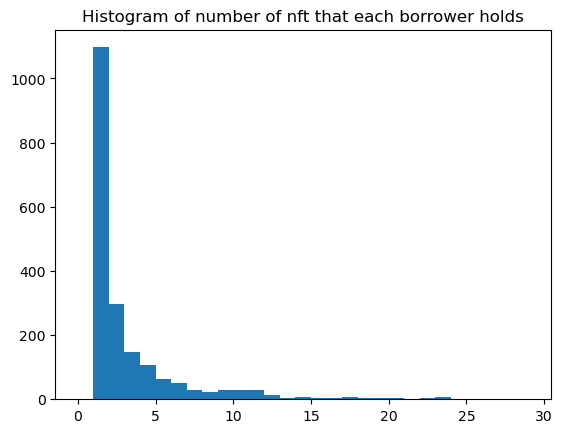

Average apr. 67.20727689741452, median 60.0, min 0.0, max 2607.14
LTV Avg 13.99056917985786, Median, 0.7810622446527277, Min 0.0005349596105494035, Max 2272.7272727272725


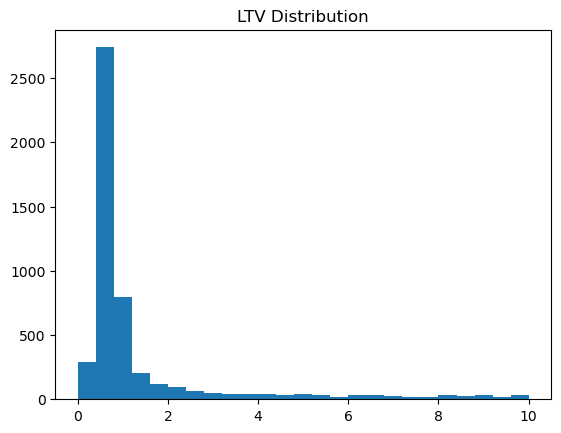

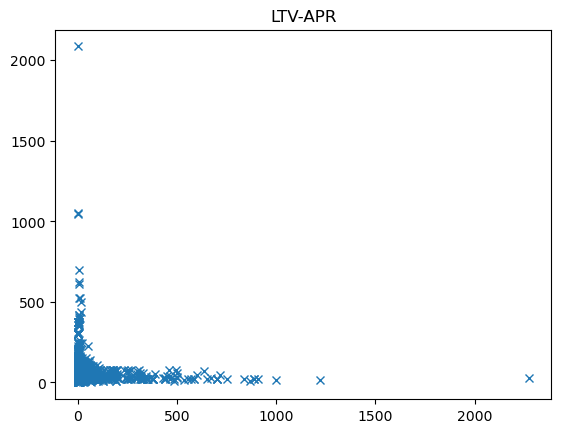

Loan Duration avg. 30.24180865006553, median 30.0, min 1.0, max 365.0


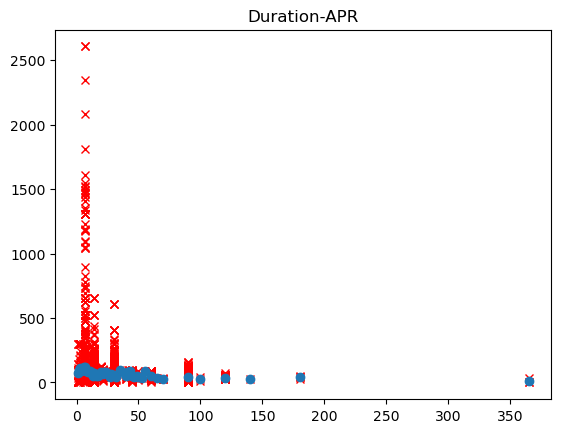

Average default rate 0.08900274037888717


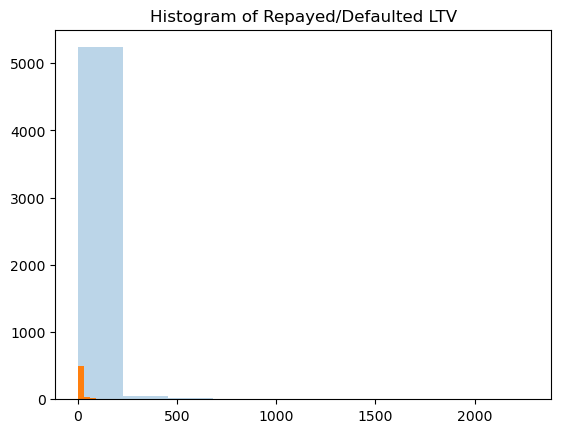

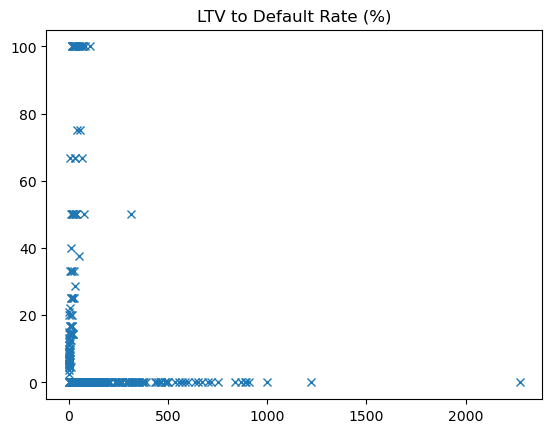

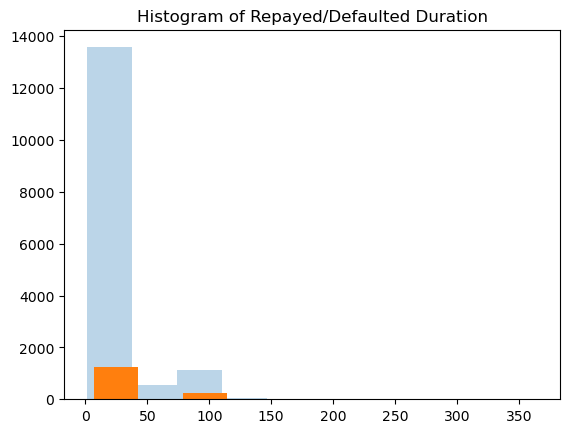

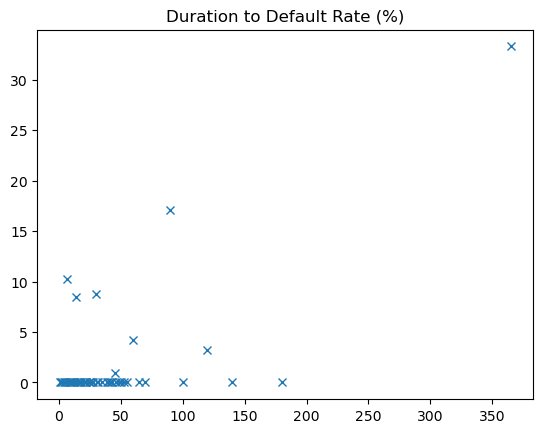

In [4]:
print_stat(loan_info)

## BAYC Statistics

# Unique loan: 547
Loan total amount: 25396.661985068495 wETH
Average principal amount: 44.4807473142596
# Unique borrower. 145


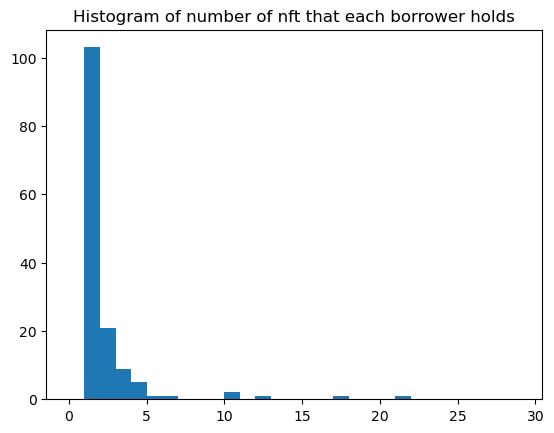

Average apr. 42.94120658135284, median 36.0, min 0.0, max 208.57
LTV Avg 0.5889474238092384, Median, 0.5882352941176471, Min 0.029565217391304348, Max 1.9204430417435838


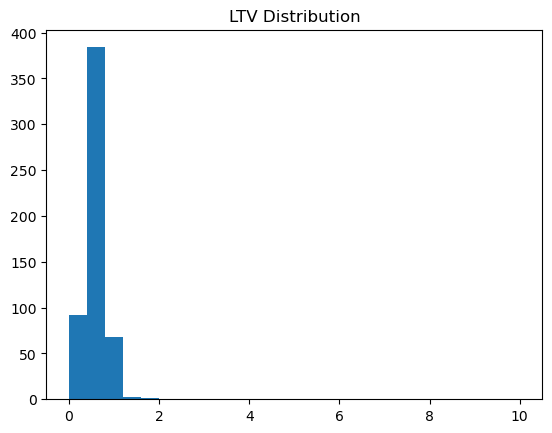

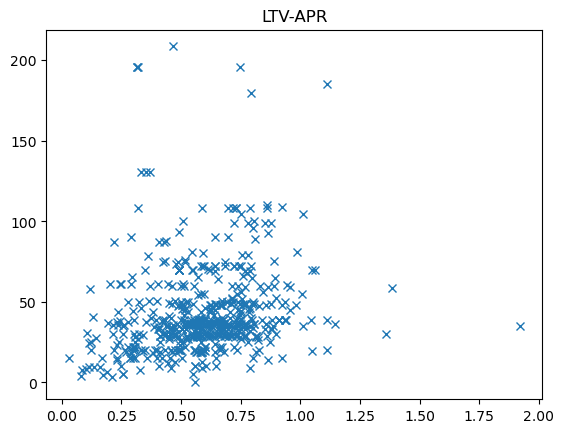

Loan Duration avg. 43.36380255941499, median 30.0, min 2.0, max 120.0


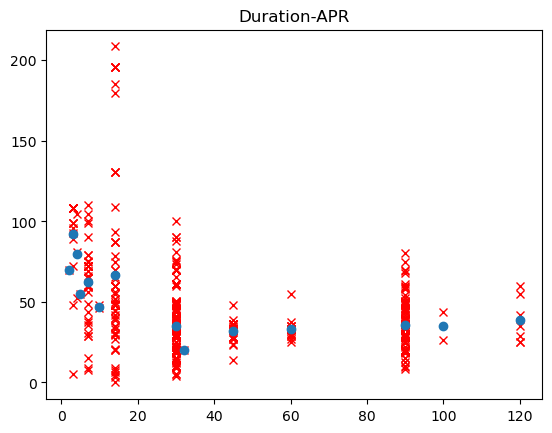

Average default rate 0.03290676416819013


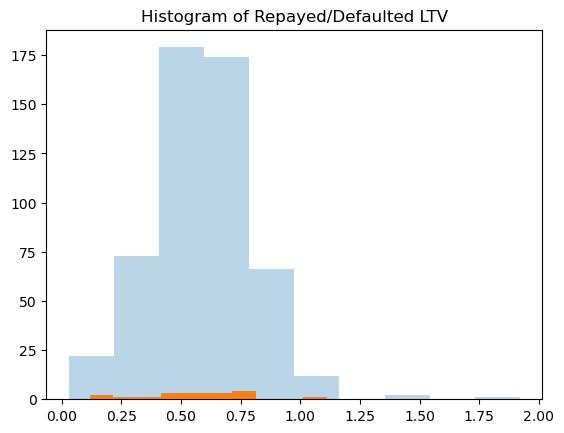

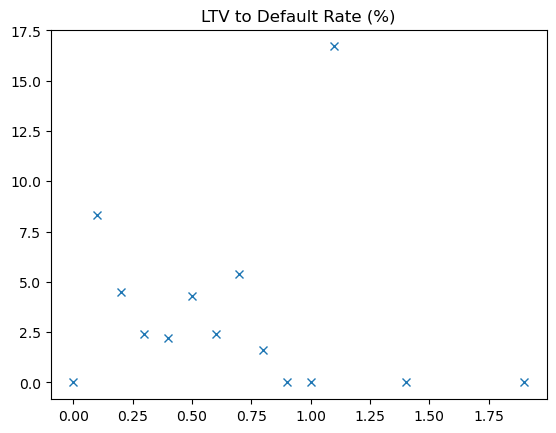

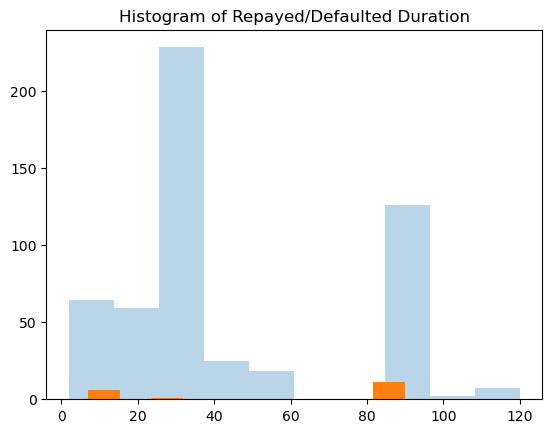

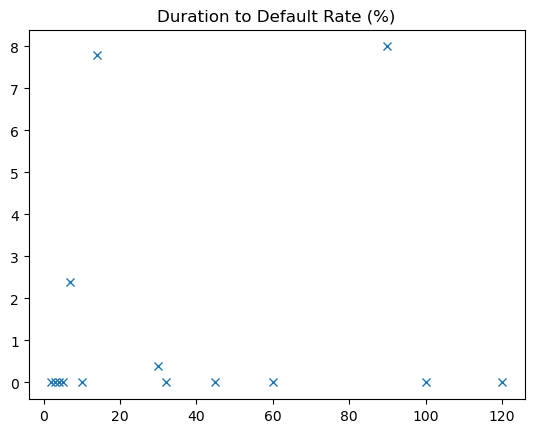


        bayc profit after liquidation: 
             #Liquidated 18, 
             #Sold 2, 
             Ratio: 0.1111111111111111 
             Average Profit 341.805556%
             Median Profit 341.805556%"
        


In [5]:
CONTRACT_NAME = "bayc"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## MAYC

# Unique loan: 739
Loan total amount: 9534.322231182792 wETH
Average principal amount: 12.342888487545753
# Unique borrower. 240


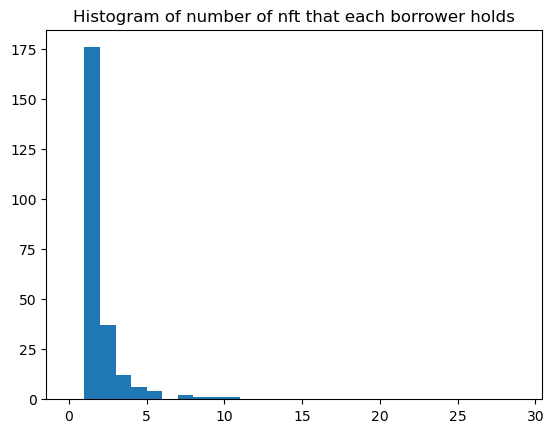

Average apr. 51.30274695534506, median 42.0, min 0.0, max 312.86
LTV Avg 0.687794485858436, Median, 0.663345390022521, Min 0.0028571428571428567, Max 2.3273855702094646


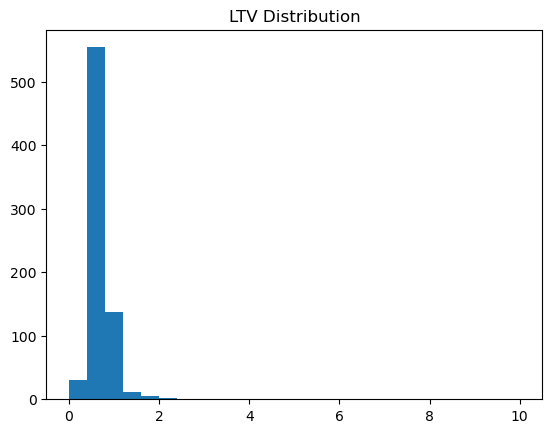

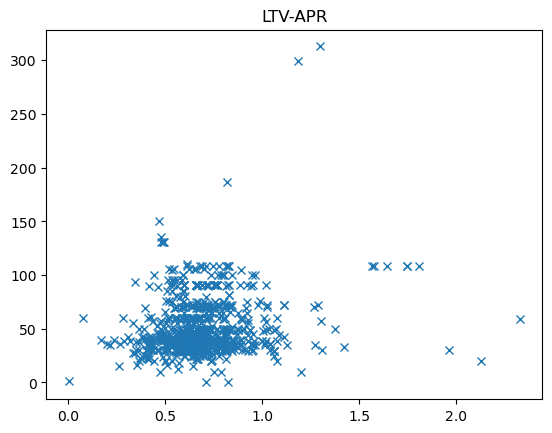

Loan Duration avg. 38.129905277401896, median 30.0, min 3.0, max 120.0


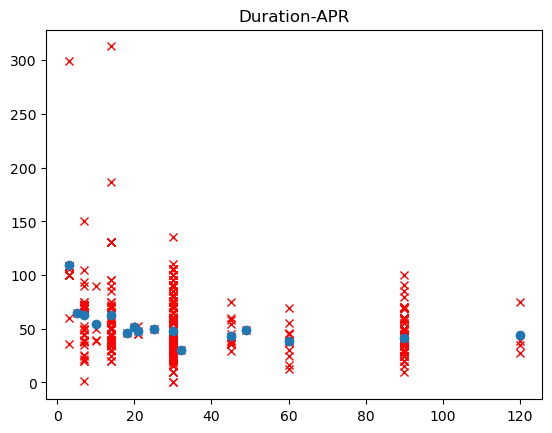

Average default rate 0.07577807848443843


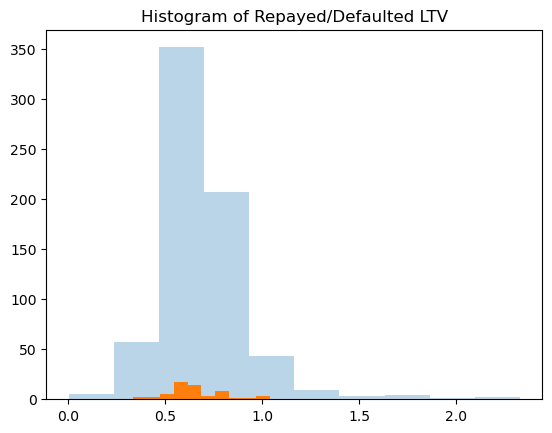

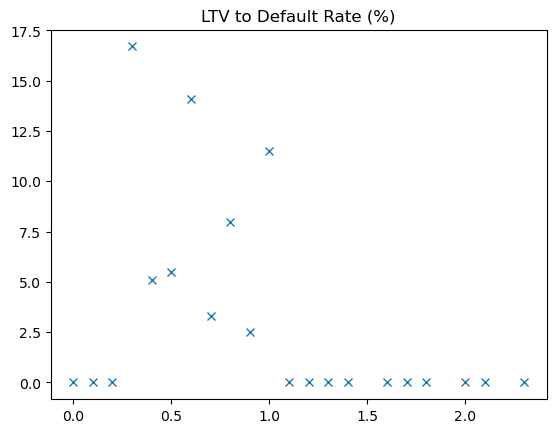

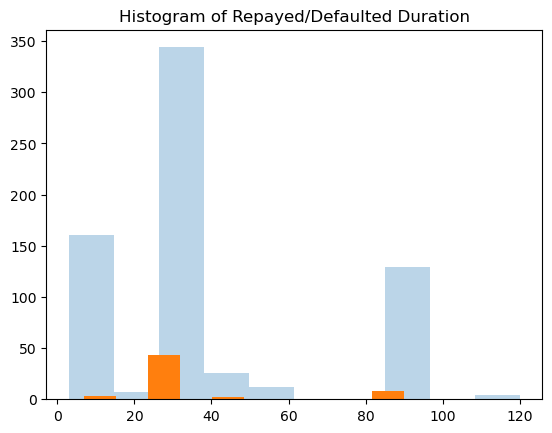

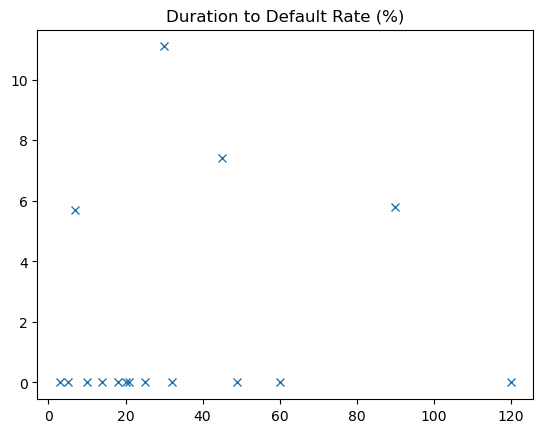


        mayc profit after liquidation: 
             #Liquidated 56, 
             #Sold 23, 
             Ratio: 0.4107142857142857 
             Average Profit 141.614265%
             Median Profit 126.333333%"
        


In [16]:
CONTRACT_NAME = "mayc"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## Crypto Punks

# Unique loan: 72
Loan total amount: 3105.4549354109586 wETH
Average principal amount: 41.76111111111111
# Unique borrower. 32


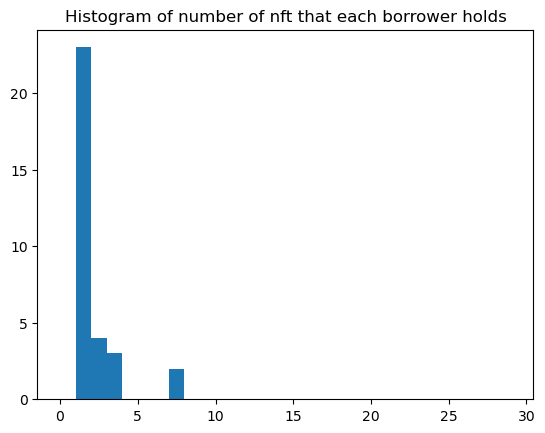

Average apr. 26.020972222222223, median 20.0, min 8.0, max 102.82
LTV Avg 0.6926037089822022, Median, 0.6816562244793725, Min 0.0014410986936440342, Max 1.6011499814978225


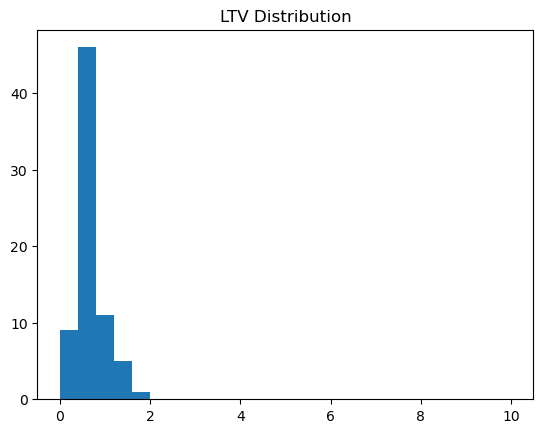

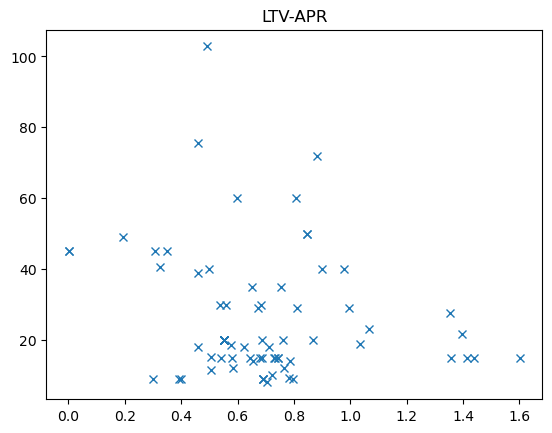

Loan Duration avg. 47.666666666666664, median 30.0, min 7.0, max 100.0


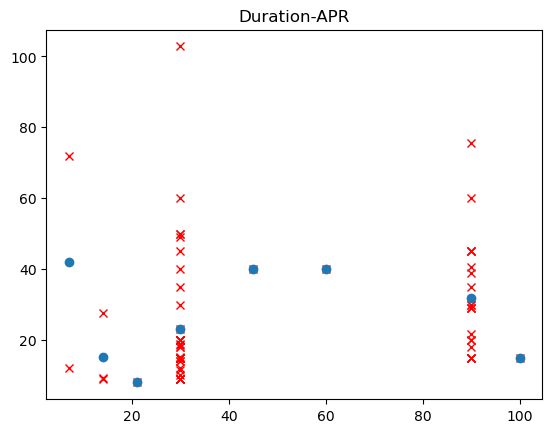

Average default rate 0.20833333333333334


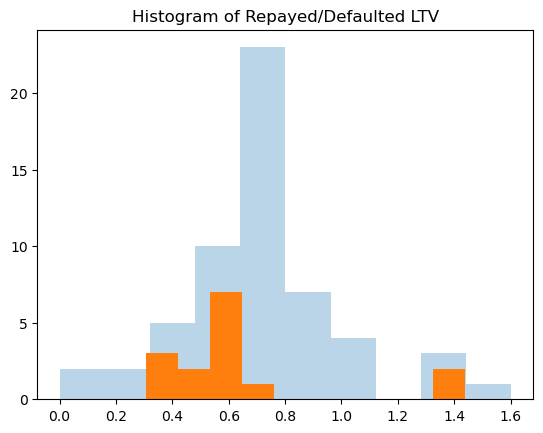

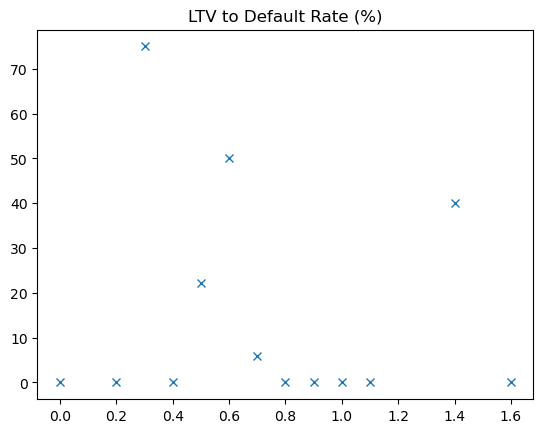

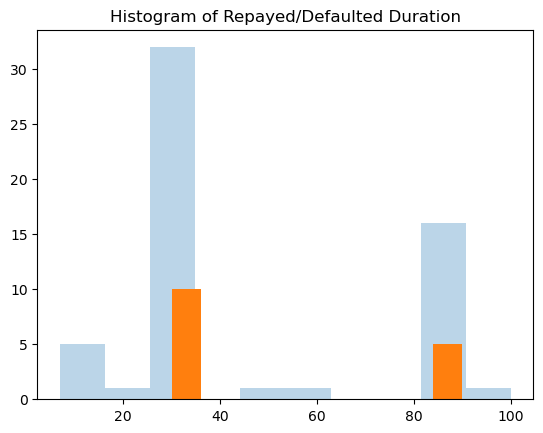

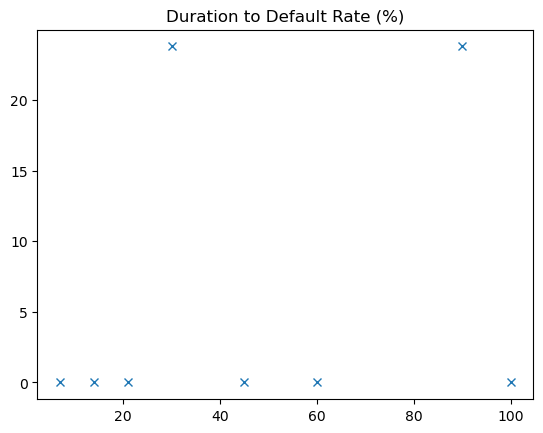


        cryptopunks profit after liquidation: 
             #Liquidated 15, 
             #Sold 0, 
             Ratio: 0.0 
             Average Profit nan%
             Median Profit nan%"
        


In [6]:
CONTRACT_NAME = "cryptopunks"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## Doodles

# Unique loan: 583
Loan total amount: 5649.831477309828 wETH
Average principal amount: 9.269258414420015
# Unique borrower. 158


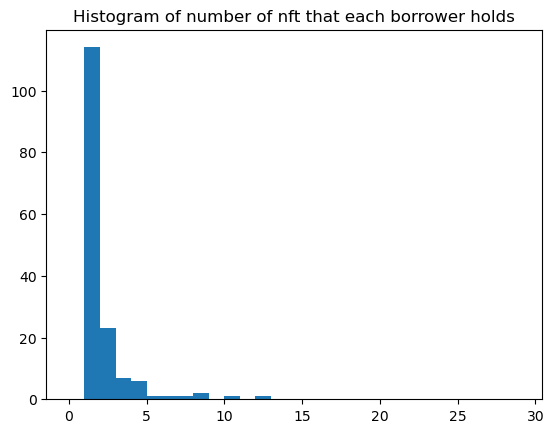

Average apr. 46.04296740994854, median 40.0, min 0.0, max 243.33
LTV Avg 0.7825939546428311, Median, 0.6459263392857143, Min 0.1400128428571078, Max 6.403978742731484


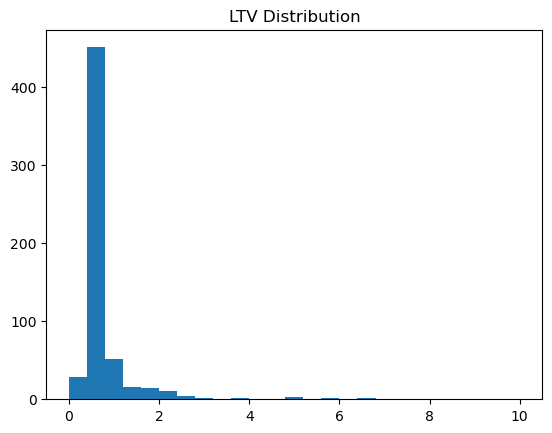

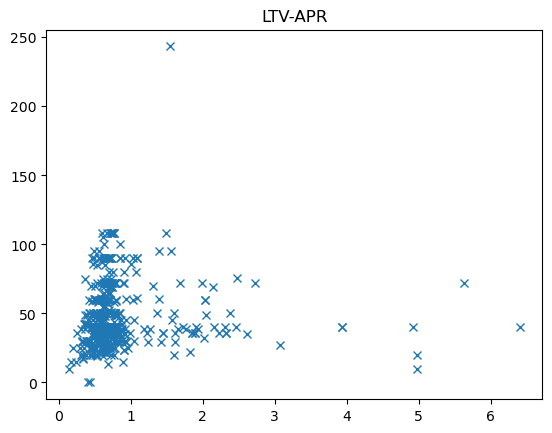

Loan Duration avg. 37.95368782161235, median 30.0, min 1.0, max 180.0


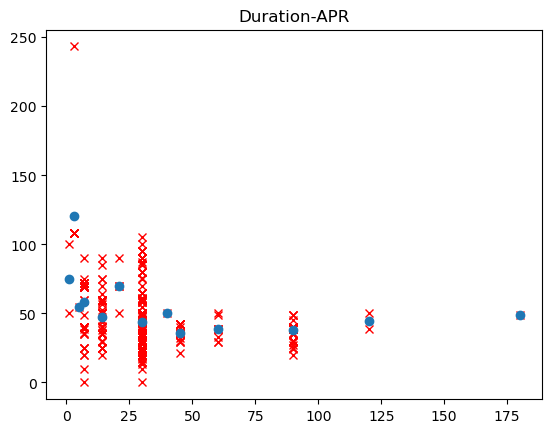

Average default rate 0.18524871355060035


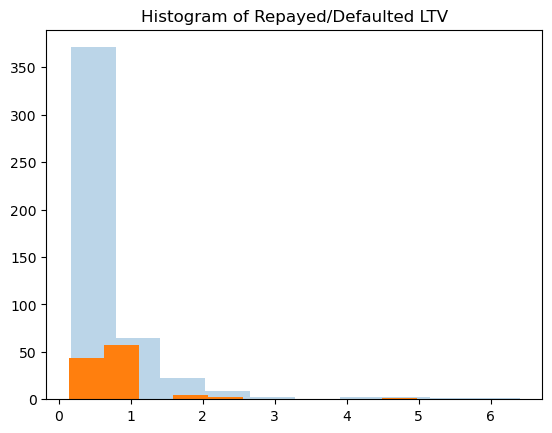

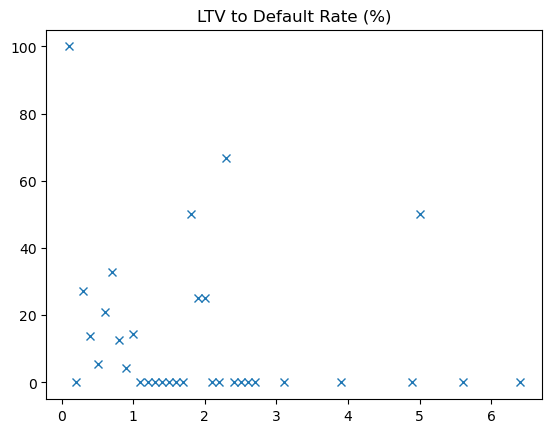

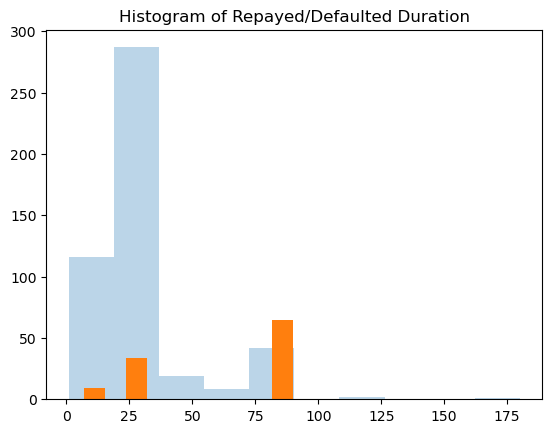

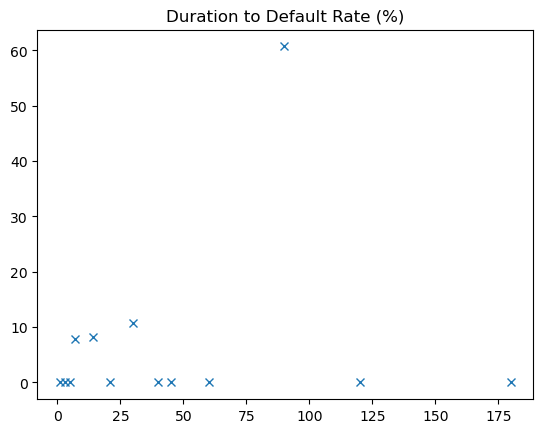


        doodles profit after liquidation: 
             #Liquidated 108, 
             #Sold 7, 
             Ratio: 0.06481481481481481 
             Average Profit 177.089390%
             Median Profit 166.111111%"
        


In [7]:
CONTRACT_NAME = "doodles"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## World of Woman

# Unique loan: 629
Loan total amount: 3769.256557583354 wETH
Average principal amount: 5.663522621349197
# Unique borrower. 98


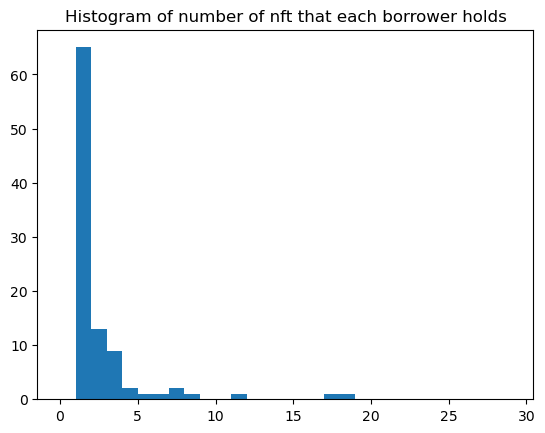

Average apr. 64.65988871224165, median 70.49, min 0.0, max 172.0
LTV Avg 1.2285292999667146, Median, 0.845809016324114, Min 0.13597904915392184, Max 10.843373493975903


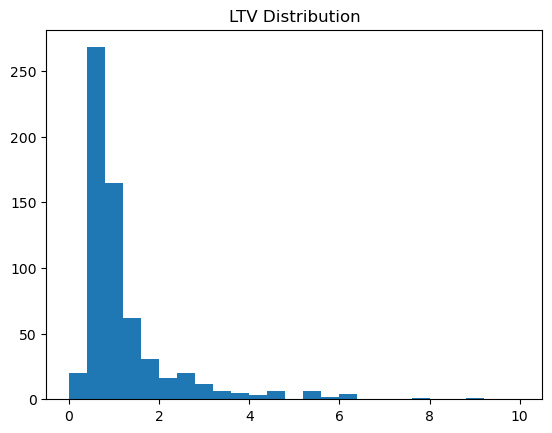

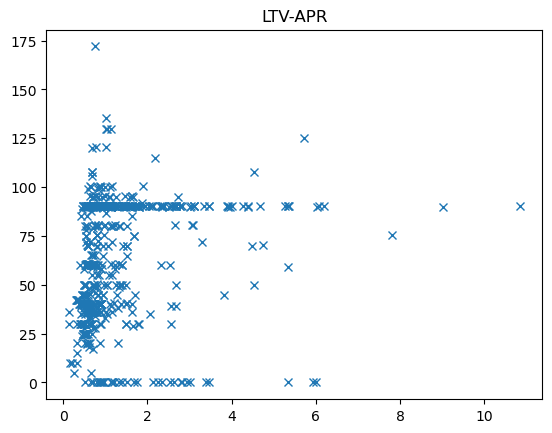

Loan Duration avg. 31.527821939586644, median 30.0, min 1.0, max 120.0


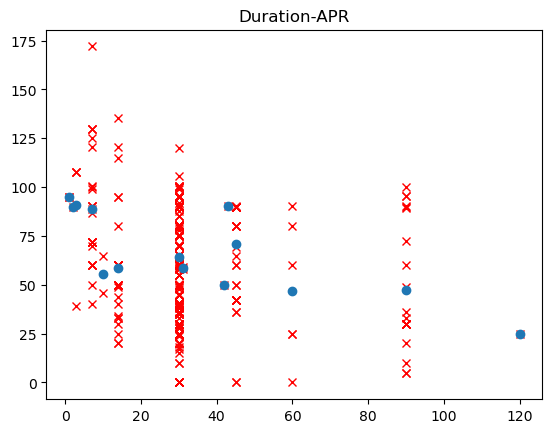

Average default rate 0.07472178060413355


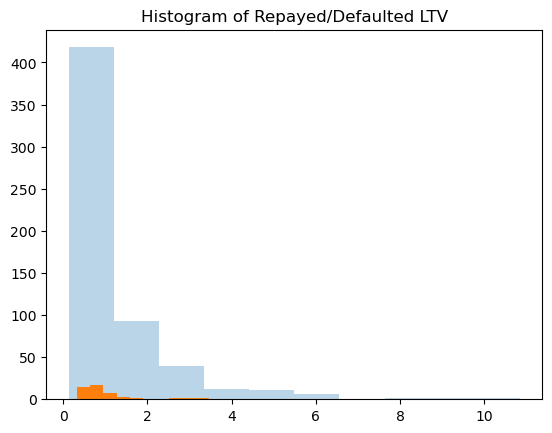

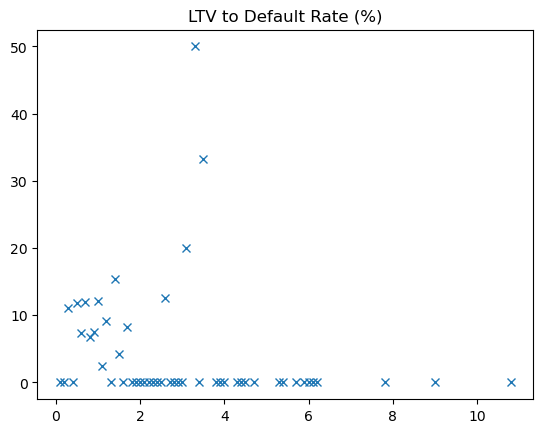

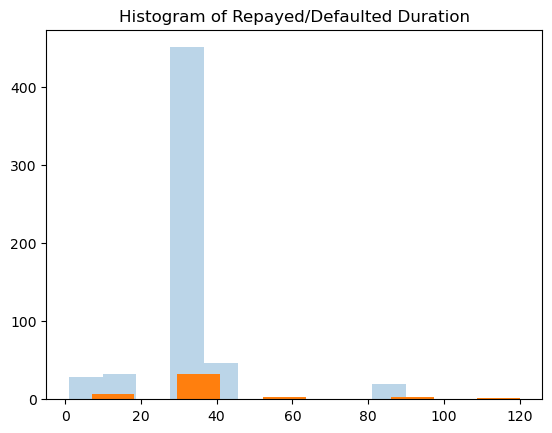

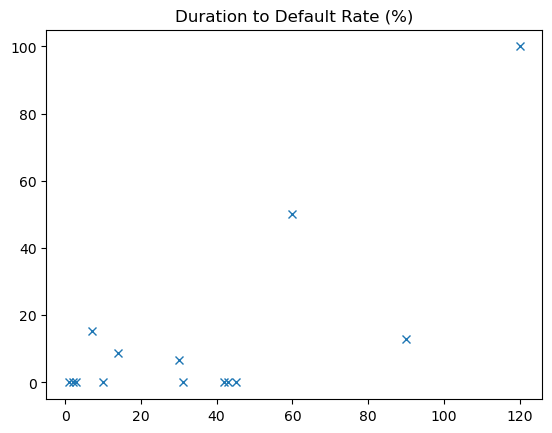


        worldofwomen profit after liquidation: 
             #Liquidated 47, 
             #Sold 6, 
             Ratio: 0.1276595744680851 
             Average Profit 97.739259%
             Median Profit 89.000000%"
        


In [8]:
CONTRACT_NAME = "worldofwomen"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## Art Blocks1

# Unique loan: 1593
Loan total amount: 6804.450941486733 wETH
Average principal amount: 4.107543639848393
# Unique borrower. 178


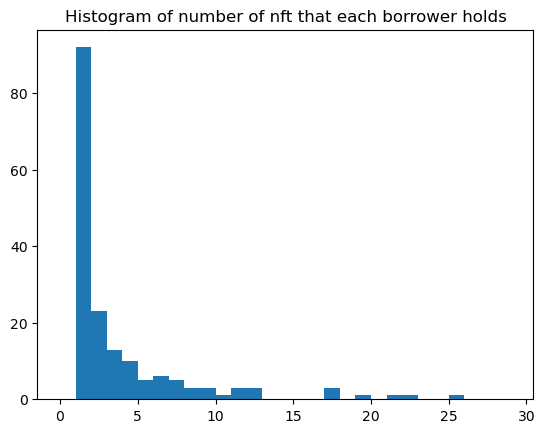

Average apr. 71.95414312617702, median 60.0, min 0.0, max 2085.71
LTV Avg 49.218135783736365, Median, 15.0, Min 0.0005349596105494035, Max 2272.7272727272725


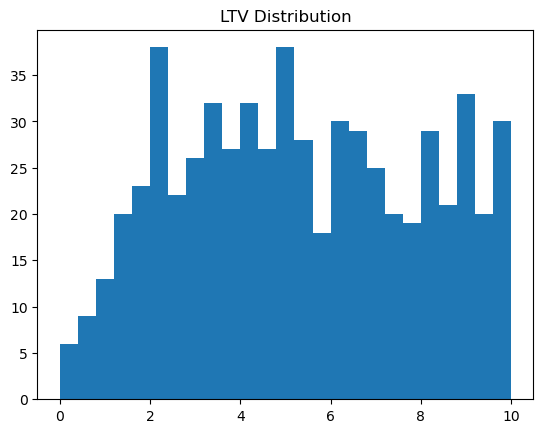

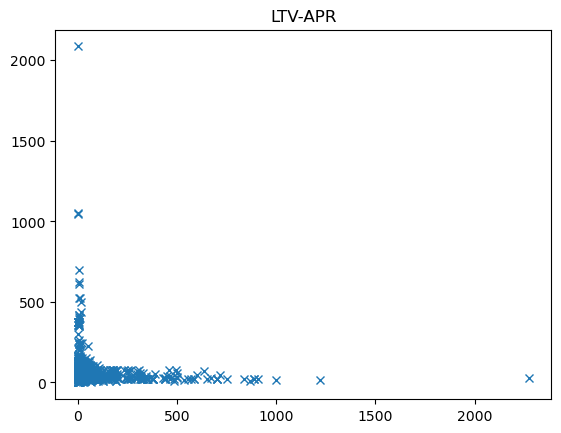

Loan Duration avg. 28.382297551789076, median 30.0, min 3.0, max 90.0


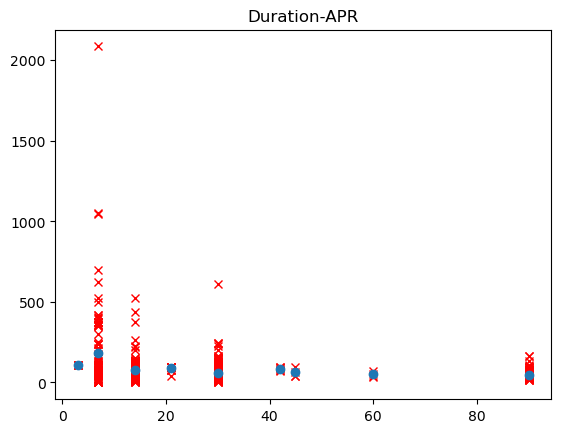

Average default rate 0.08097928436911488


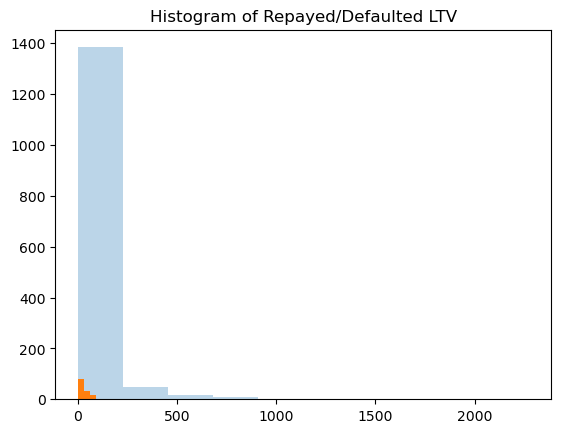

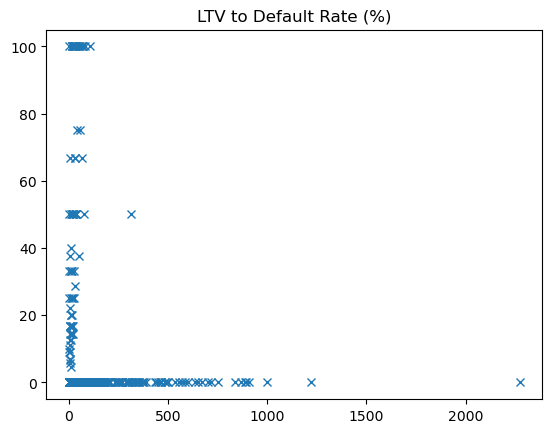

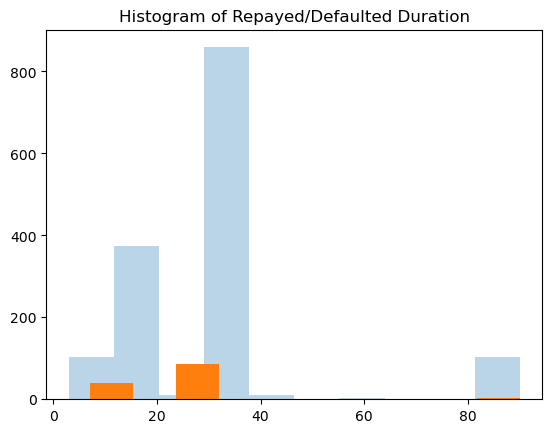

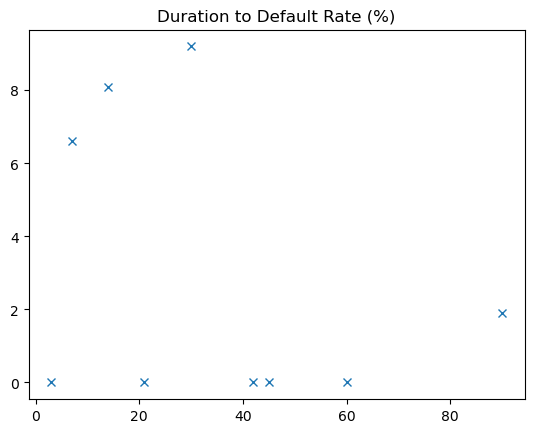

KeyError: 'data'

In [9]:
CONTRACT_NAME = "artblock1"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## Art Blocks2

# Unique loan: 318
Loan total amount: 2408.082941438356 wETH
Average principal amount: 7.328773487421382
# Unique borrower. 76


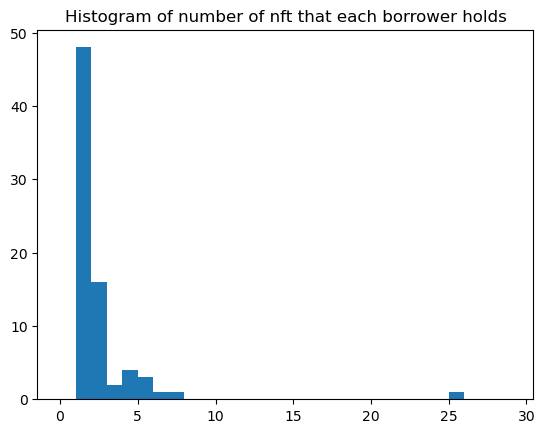

Average apr. 35.21103773584906, median 25.0, min 0.1, max 228.02
LTV Avg 1.254435078049426, Median, 0.8274527417159565, Min 0.0011235955056179774, Max 18.26994780014914


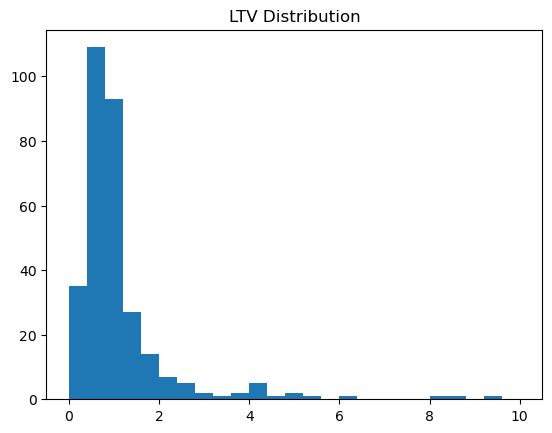

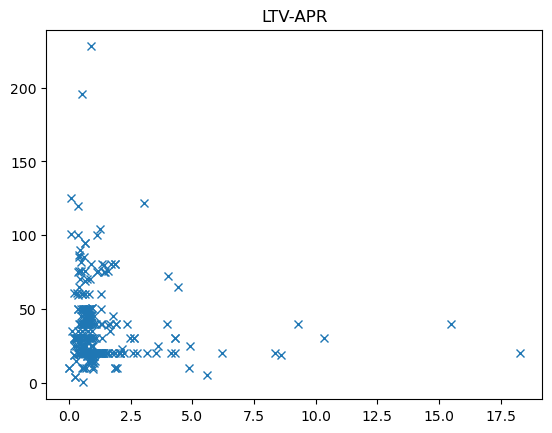

Loan Duration avg. 38.25471698113208, median 30.0, min 3.0, max 180.0


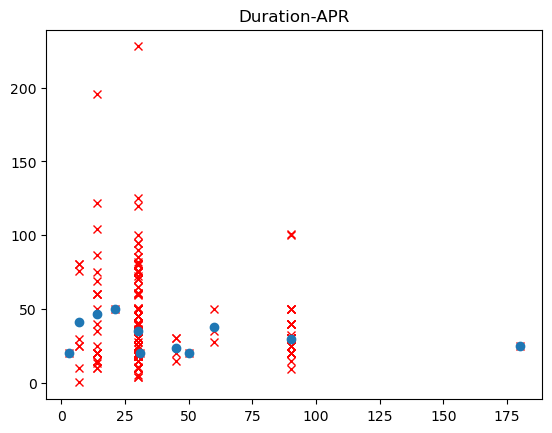

Average default rate 0.03459119496855346


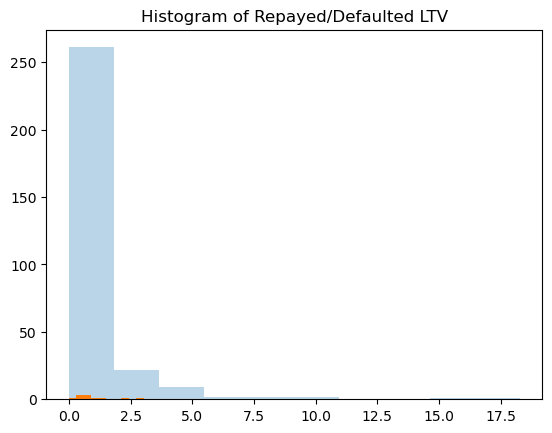

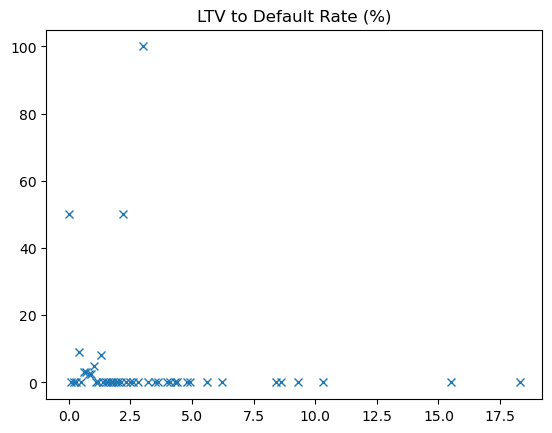

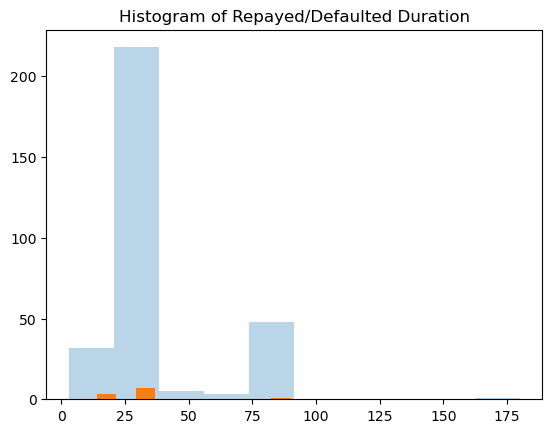

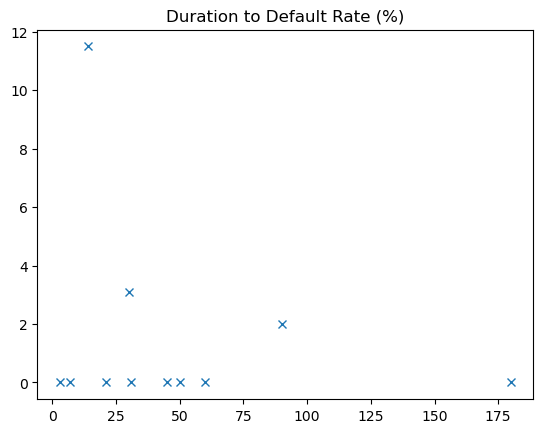


        artblock2 profit after liquidation: 
             #Liquidated 11, 
             #Sold 2, 
             Ratio: 0.18181818181818182 
             Average Profit 540.625000%
             Median Profit 540.625000%"
        


In [11]:
CONTRACT_NAME = "artblock2"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## CloneX

# Unique loan: 449
Loan total amount: 3962.629850666418 wETH
Average principal amount: 8.398113972261415
# Unique borrower. 129


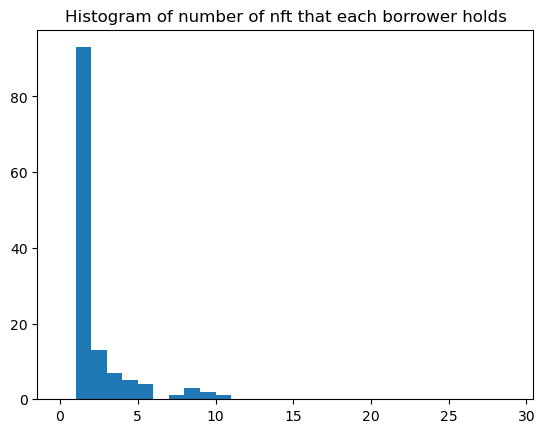

Average apr. 61.689977728285086, median 49.99, min 10.0, max 299.0
LTV Avg 0.7833810327901756, Median, 0.6862011804620878, Min 0.17652250661959398, Max 5.509641873278237


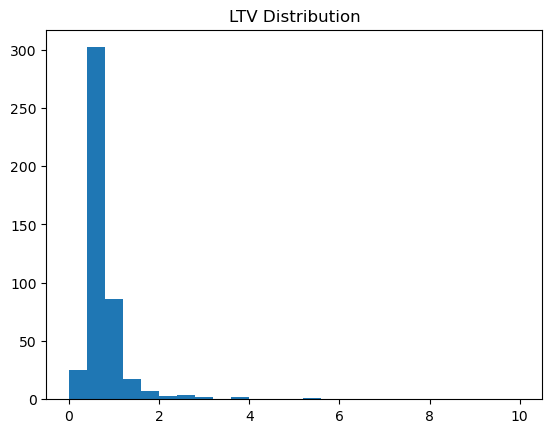

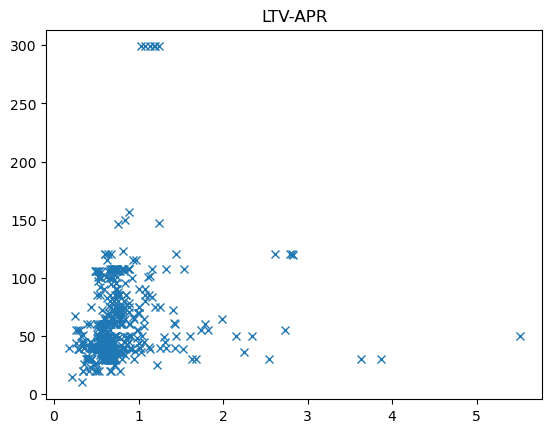

Loan Duration avg. 33.661469933184854, median 30.0, min 1.0, max 90.0


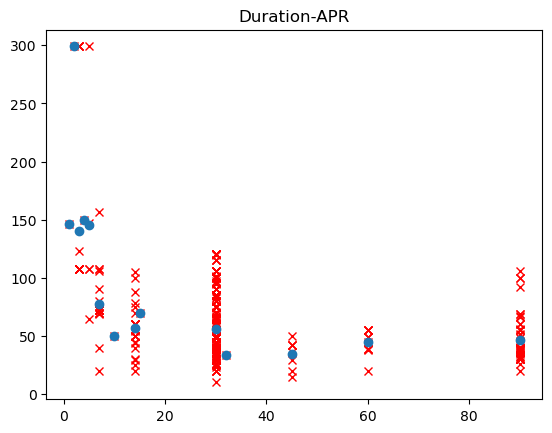

Average default rate 0.11358574610244988


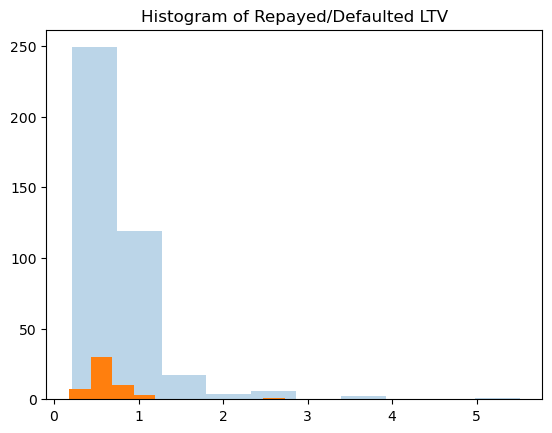

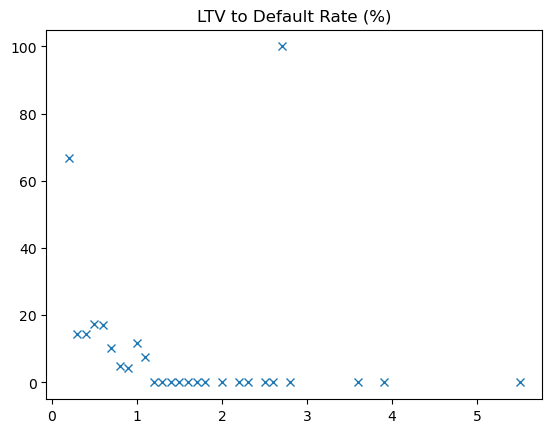

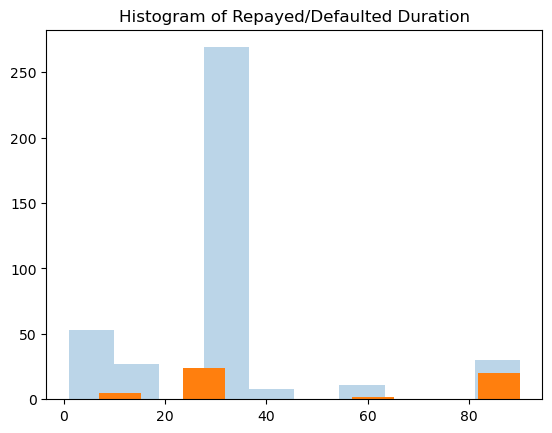

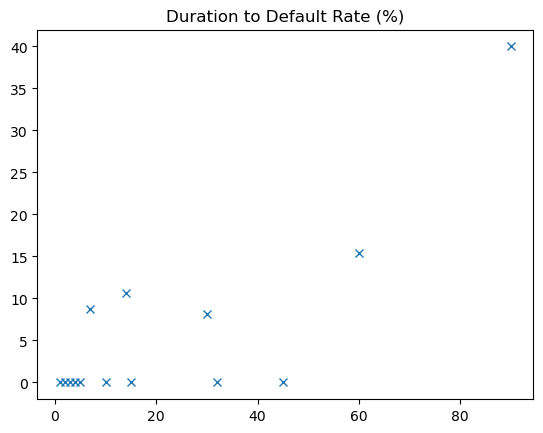


        clonex profit after liquidation: 
             #Liquidated 51, 
             #Sold 10, 
             Ratio: 0.19607843137254902 
             Average Profit 165.704017%
             Median Profit 165.436508%"
        


In [12]:
CONTRACT_NAME = "clonex"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## Azuki

# Unique loan: 318
Loan total amount: 3395.6043265545404 wETH
Average principal amount: 10.259224280535541
# Unique borrower. 113


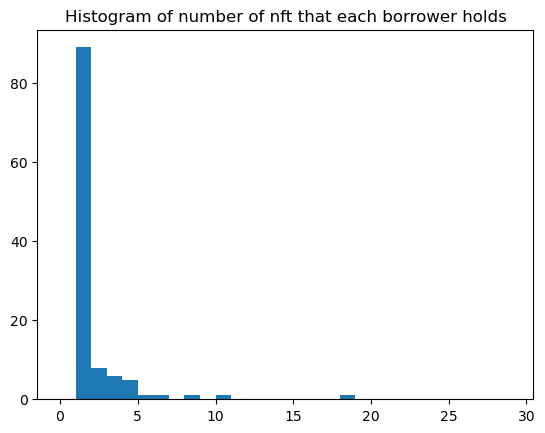

Average apr. 53.13694968553459, median 45.0, min 12.0, max 140.49
LTV Avg 0.7467892660149558, Median, 0.6555481122893942, Min 0.3016705003959425, Max 3.8253108065030283


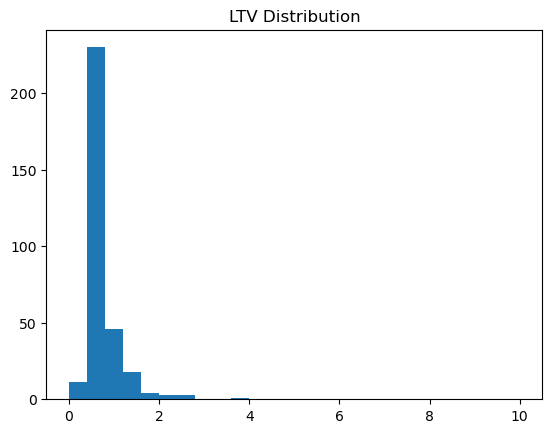

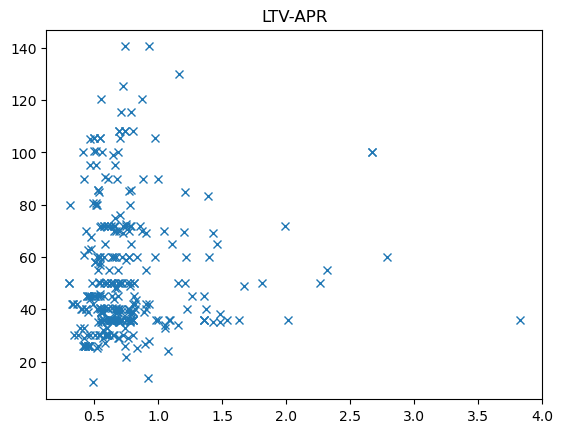

Loan Duration avg. 31.88050314465409, median 30.0, min 3.0, max 90.0


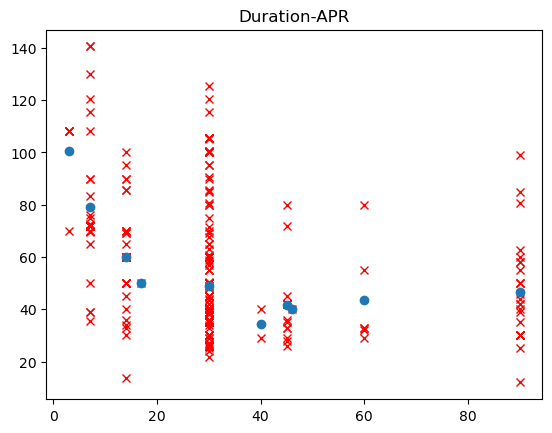

Average default rate 0.11320754716981132


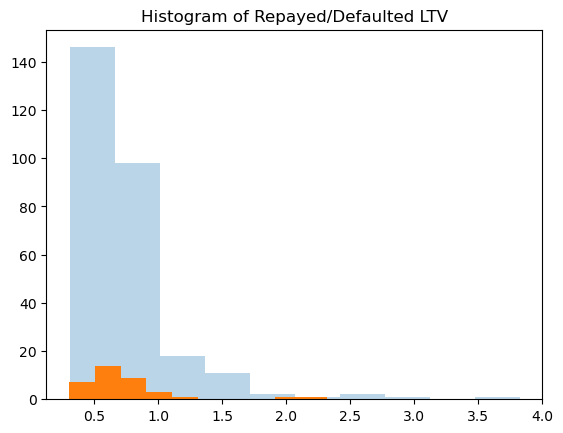

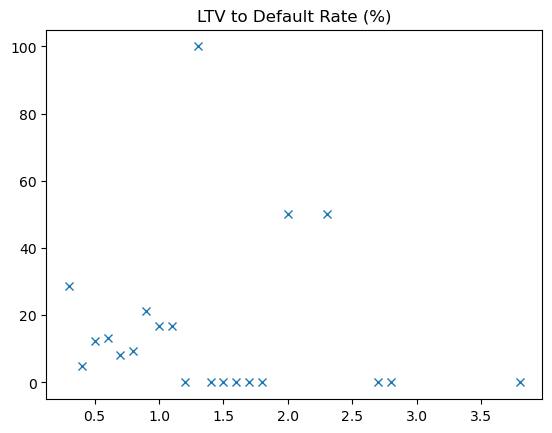

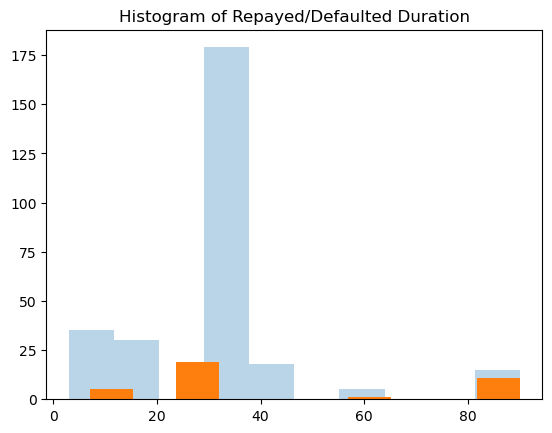

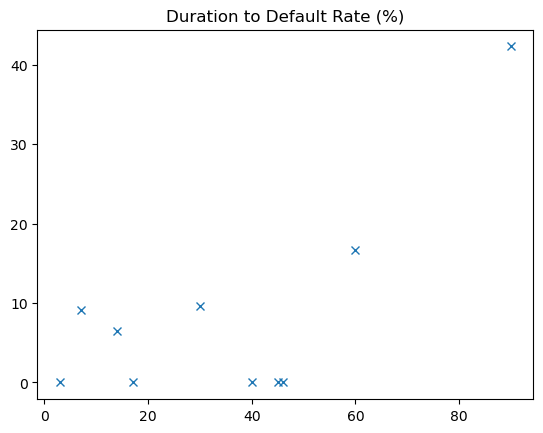


        azuki profit after liquidation: 
             #Liquidated 36, 
             #Sold 14, 
             Ratio: 0.3888888888888889 
             Average Profit 94.206290%
             Median Profit 76.862745%"
        


In [13]:
CONTRACT_NAME = "azuki"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## sandbox

# Unique loan: 355
Loan total amount: 516.1600461369862 wETH
Average principal amount: 1.370258399175486
# Unique borrower. 70


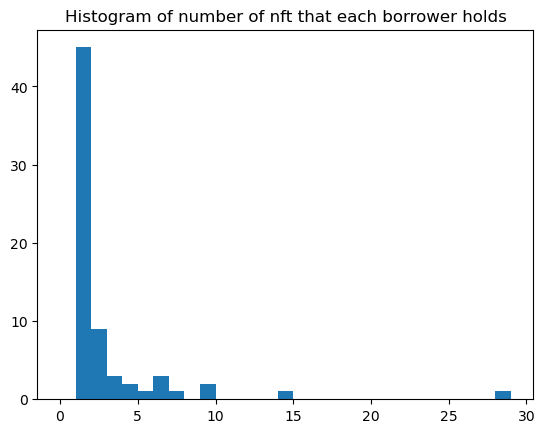

Average apr. 73.45991549295775, median 53.49, min 0.0, max 651.79
LTV Avg 0.6902125751665718, Median, 0.6162273194111605, Min 0.4025764895330113, Max 2.25


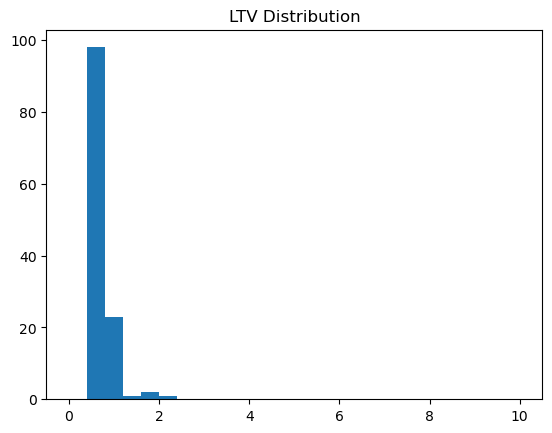

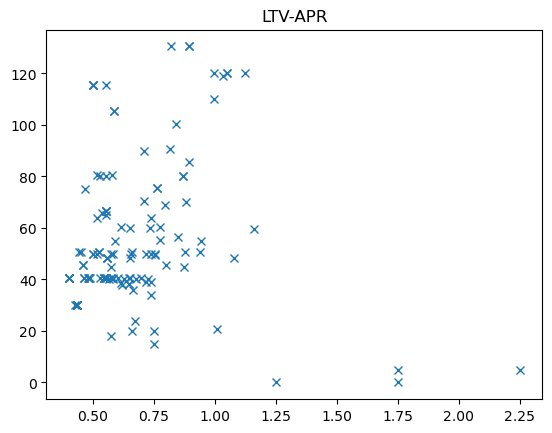

Loan Duration avg. 43.501408450704226, median 30.0, min 7.0, max 90.0


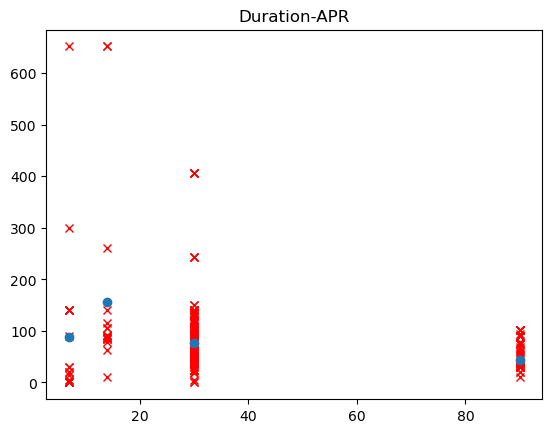

Average default rate 0.07887323943661972


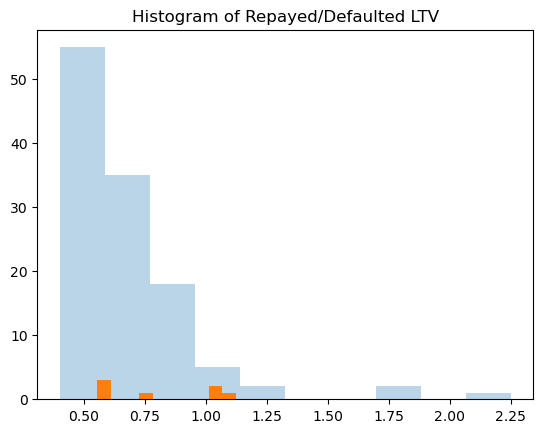

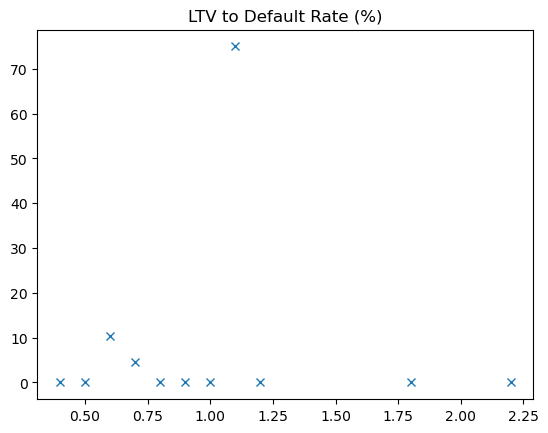

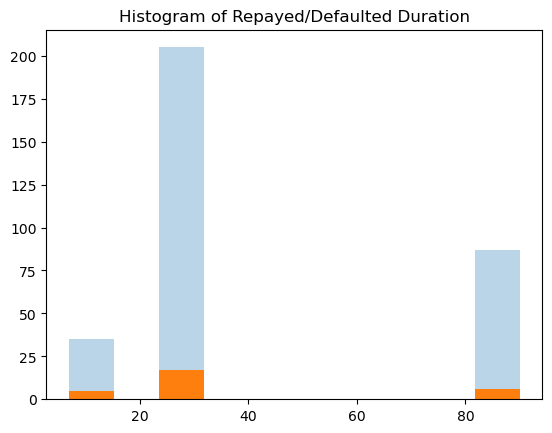

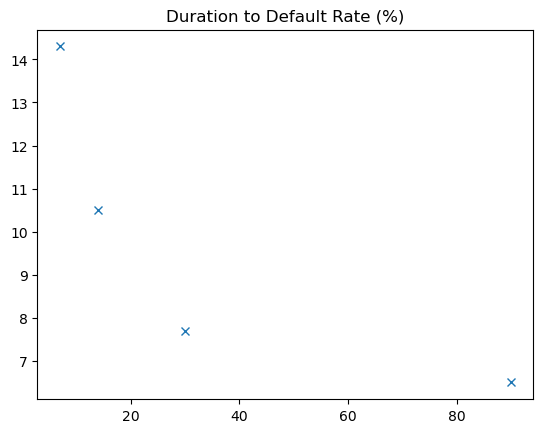


        sandbox profit after liquidation: 
             #Liquidated 28, 
             #Sold 10, 
             Ratio: 0.35714285714285715 
             Average Profit 266.419167%
             Median Profit 204.861111%"
        


In [14]:
CONTRACT_NAME = "sandbox"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)

## Coolcats

# Unique loan: 197
Loan total amount: 909.3811505068493 wETH
Average principal amount: 4.372570811675127
# Unique borrower. 73


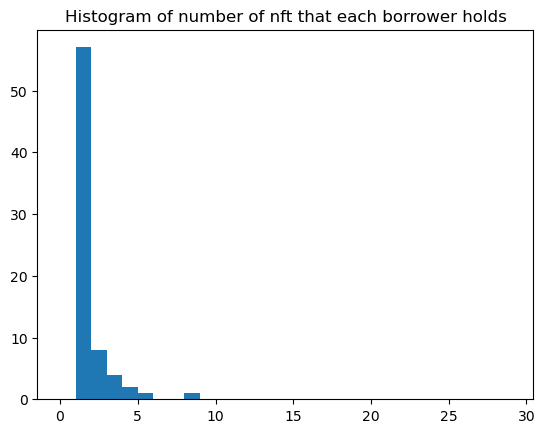

Average apr. 62.41751269035533, median 60.0, min 0.0, max 243.33
LTV Avg 0.7572528053486391, Median, 0.6218905472636816, Min 0.29333333333333333, Max 11.448919245345882


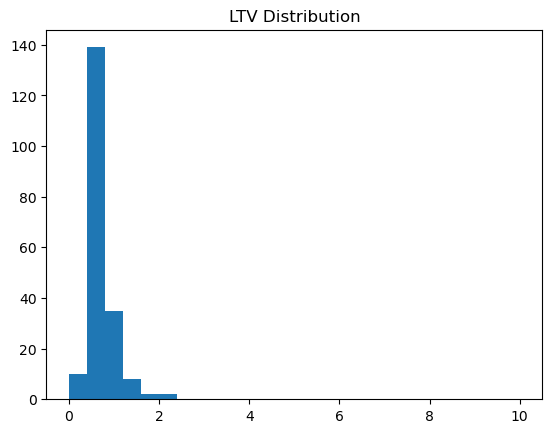

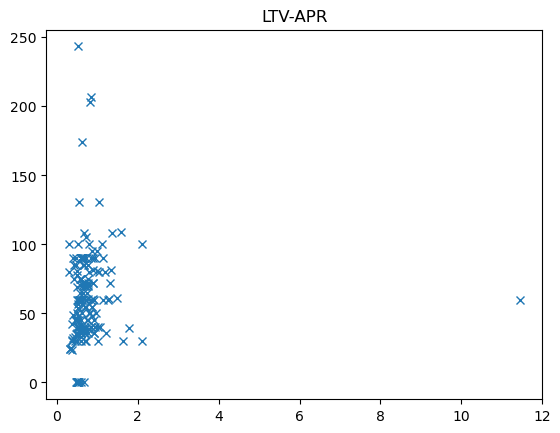

Loan Duration avg. 34.32994923857868, median 30.0, min 3.0, max 120.0


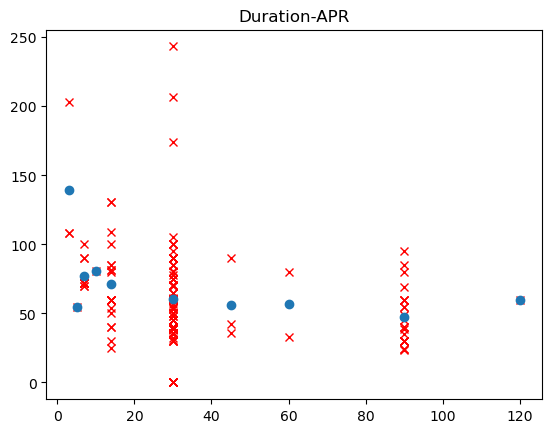

Average default rate 0.1218274111675127


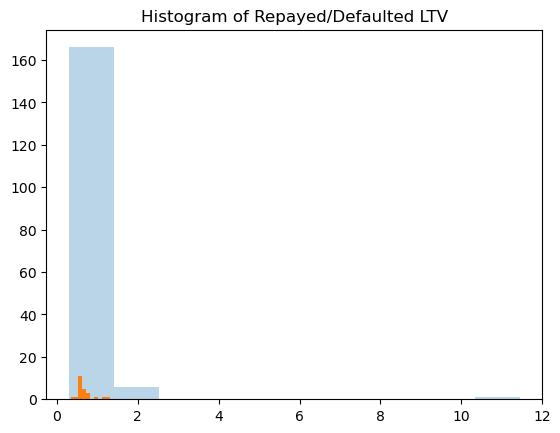

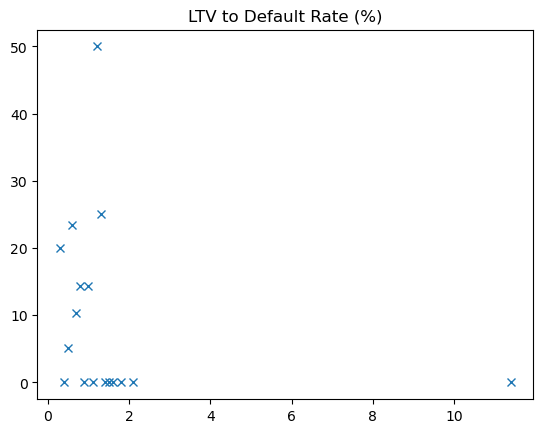

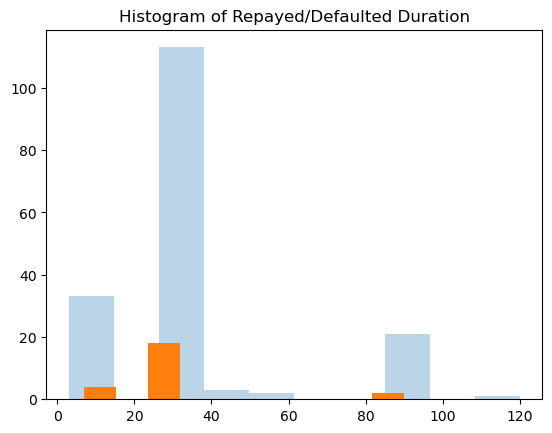

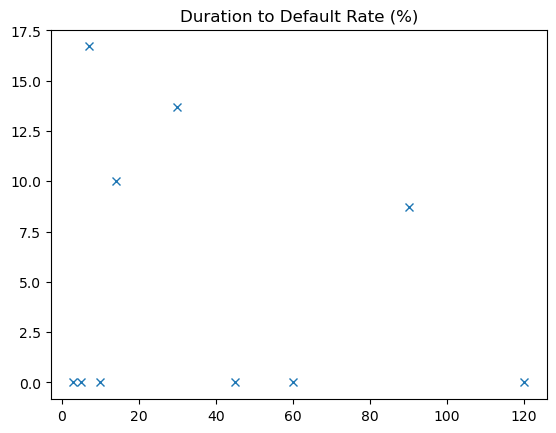

KeyError: 'nft_token_ids_array'

In [15]:
CONTRACT_NAME = "coolcats"
print_stat(loan_info[loan_info["nftCollateralContract"] == CONTRACT_ADDRESS[CONTRACT_NAME]])
computeProfitAfterSale(loan_info, CONTRACT_NAME)